In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ExtendedConeBeamDCC import *
from TextFileSaving import * 
from AllAcquisitionCD_Beta_Class import *
from ConeBeamDCCWithBackprojectionPlane import *
from tqdm import tqdm_notebook
%matplotlib notebook
import time
from WeLovePlots import *
import itertools
import matplotlib.lines as mlines

In [3]:
filesdir_ref = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/3D_patients/AM6/donneesBrutes/inspi_bloquee/"
# reading projections
proj = itk.imread(filesdir_ref+"corrected_proj.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

# bt_120 = np.genfromtxt('/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/doc/bowtie/BowTieProfilesFiles/Wedge_120_w1.txt', skip_header=1, unpack=True).T
# supp_current = np.genfromtxt(filesdir_ref + "sans_comp_tube_current_n42_42.txt", skip_header=0, unpack=True, delimiter= ',').T

nproj = 44882
itkSize3 ([920, 32, 44882])


In [4]:
# #shrinkage
# ImageType = itk.Image[itk.F,3]
# rebin = itk.BinShrinkImageFilter[ImageType,ImageType].New()
# rebin.SetInput(proj)
# rebin.SetShrinkFactor(0,10)
# rebin.Update()
# proj_rebin = rebin.GetOutput()
# print(proj_rebin.GetSpacing())
# itk.imwrite(proj_rebin,"/home/mmouchet/Documents/Report/thesis/simu/thorax_phantom/shrink10/4D_projections_thorax_10x360_920x1028_shrink10.mha") 

# I0=10**5
# dH2O=0.01879 #mm^-1 at 75 keV
# if I0!=0:
#     new_sino = I0*np.exp(-1.*dH2O*itk.GetArrayFromImage(proj_rebin))
#     new_sino = np.maximum(np.random.poisson(new_sino), 1)
#     new_sino = np.log(I0/new_sino)/dH2O
#     proj_rebin_n = itk.GetImageFromArray(new_sino.astype(np.float32))
#     proj_rebin_n.CopyInformation(proj_rebin)
#     proj_rebin_n.Update()
#     itk.imwrite(proj_rebin_n,"/home/mmouchet/Documents/Report/thesis/simu/thorax_phantom/shrink10/4D_projections_thorax_10x360_920x1028_shrink10_noise.mha") 

#Convert to array for faster computation directly on the physical detector
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)

AcquiDCC = DCCOnCDinAnAcquisition(geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)
# AcquiDCC.ComputeInitialNumberOfPhotons(bt_120, supp_current)

[array([1.02806101, 1.0947541 , 1.        ]), array([0., 0., 0.]), array([  920,    32, 44882]), array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])]
300.28594765294406 200.0698969213401


In [25]:
AcquiDCC.R_fov

251.41760818230847

In [26]:
# print(np.where(np.abs(geometry_array[8,:]+50) <=0.02))
# geometry_array[8,np.where(np.abs(geometry_array[8,:]+50) <=0.02)]
# plt.figure()
# plt.plot(geometry_array[2,:])
# plt.plot(1791,geometry_array[2, 1791],"*")
# plt.plot(1791-384,geometry_array[2, 1791-384],"*")
# plt.show()

False
True
[-0.02617641  0.00640206  0.99963684] [ 0.02617641 -0.00640206 -0.99963684]


<IPython.core.display.Javascript object>


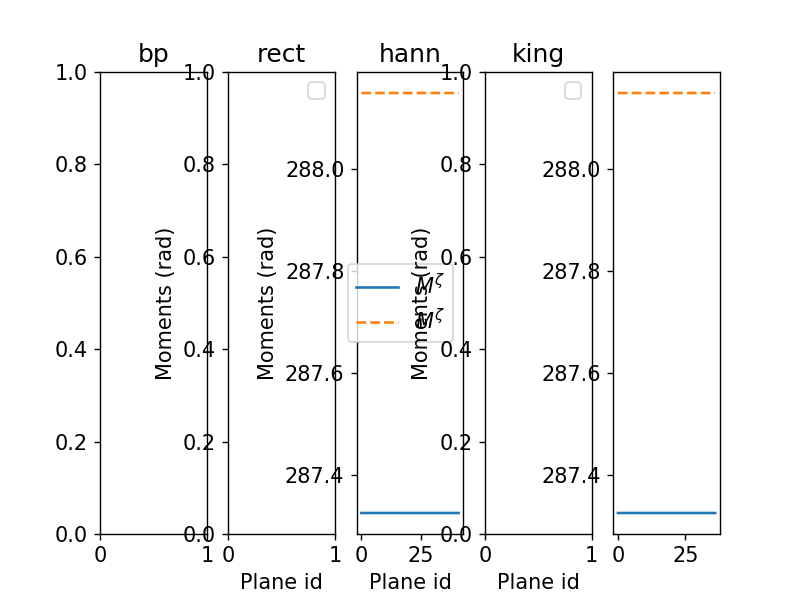

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [27]:
# Select the pair
idx0, idx1 = 720, 537

# print(geometry_array[:,idx0])
# print(geometry_array[:,idx1])
# Compute moments with backprojection plane
g0 = NPtoRTK(geometry_array, idx0)
g1 = NPtoRTK(geometry_array, idx1)
p0 = ARRAYtoRTK(proj_array, proj_infos[0], proj_infos[1], proj_infos[2], proj_infos[3], idx0)
p1 = ARRAYtoRTK(proj_array, proj_infos[0], proj_infos[1], proj_infos[2], proj_infos[3], idx1)
# itk.imwrite(p0,"/home/mmouchet/PycharmProjects/4D_study/bpm_12/neg0.mha")
# itk.imwrite(p1,"/home/mmouchet/PycharmProjects/4D_study/bpm_12/neg1.mha")
# pair_bp = ProjectionsPairBP(idx0, idx1 , g0, g1, p0, p1)
# pair_bp.LinesMomentsCorners()

pair_e = ProjectionsPairBeta(idx0, idx1 , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, AcquiDCC.Ni, '0', 'Hann', 5)
print(np.cos(AcquiDCC.geometry[2, idx1]-AcquiDCC.geometry[2, idx0]) > 2*((AcquiDCC.R_fov)/AcquiDCC.geometry[0, 0])**2-1)
# pair_e.ComputeMPoints()
# pair_e.ComputeEpipolarPlanes()
pair_e.ComputeBetaRange()
print(np.abs(np.tan(pair_e.alpha))<np.max(pair_e.v_det0)/pair_e.sdd)
pair_e.ComputePairMoments()
# pair.PlotPairMoments()

pair = ProjectionsPairMpoints(idx0, idx1 , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, AcquiDCC.Ni)
pair.ComputeMPoints()
pair.ComputeEpipolarPlanes()
pair.ComputePairMoments()

print(pair_e.eb, pair.eb)

# print(np.mean(np.abs(pair_bp.m0-pair_bp.m1)))
# print(np.mean(np.abs(pair_e.mhr0-pair_e.mhr1)))
# print(np.mean(np.abs(pair_e.m0-pair_e.m1)))
# print(np.mean(np.abs(pair_e.mk0-pair_e.mk1)))

plt.figure()
plt.rcParams['font.size'] = '12'
plt.subplot(151)
plt.title("bp")
# plt.plot(pair_bp.m0, label=r"$M(\lambda)$")
# plt.plot(pair_bp.m1, '--', label=r"$M(\lambda')$")
plt.subplot(152)
plt.title("rect")
# plt.plot(pair_e.mhr0, label=r"$M^\zeta$")
# plt.plot(pair_e.mhr1,'--', label=r"$M^{\zeta}$")
plt.legend()
plt.xlabel("Plane id")
plt.ylabel("Moments (rad)")
plt.subplot(153)
plt.title("hann")
plt.plot(pair_e.m0, label=r"$M^\zeta$")
plt.plot(pair_e.m1,'--', label=r"$M^{\zeta}$")
plt.legend()
plt.xlabel("Plane id")
plt.ylabel("Moments (rad)")
plt.subplot(154)
plt.title("king")
# plt.plot(pair_e.mk0, label=r"$M^\zeta$")
# plt.plot(pair_e.mk1,'--', label=r"$M^{\zeta}$")
plt.legend()
plt.xlabel("Plane id")
plt.ylabel("Moments (rad)")
plt.subplot(155)
plt.plot(pair.mhh0, label=r"$M^\zeta$")
plt.plot(pair.mhh1,'--', label=r"$M^{\zeta}$")
plt.show()


<IPython.core.display.Javascript object>


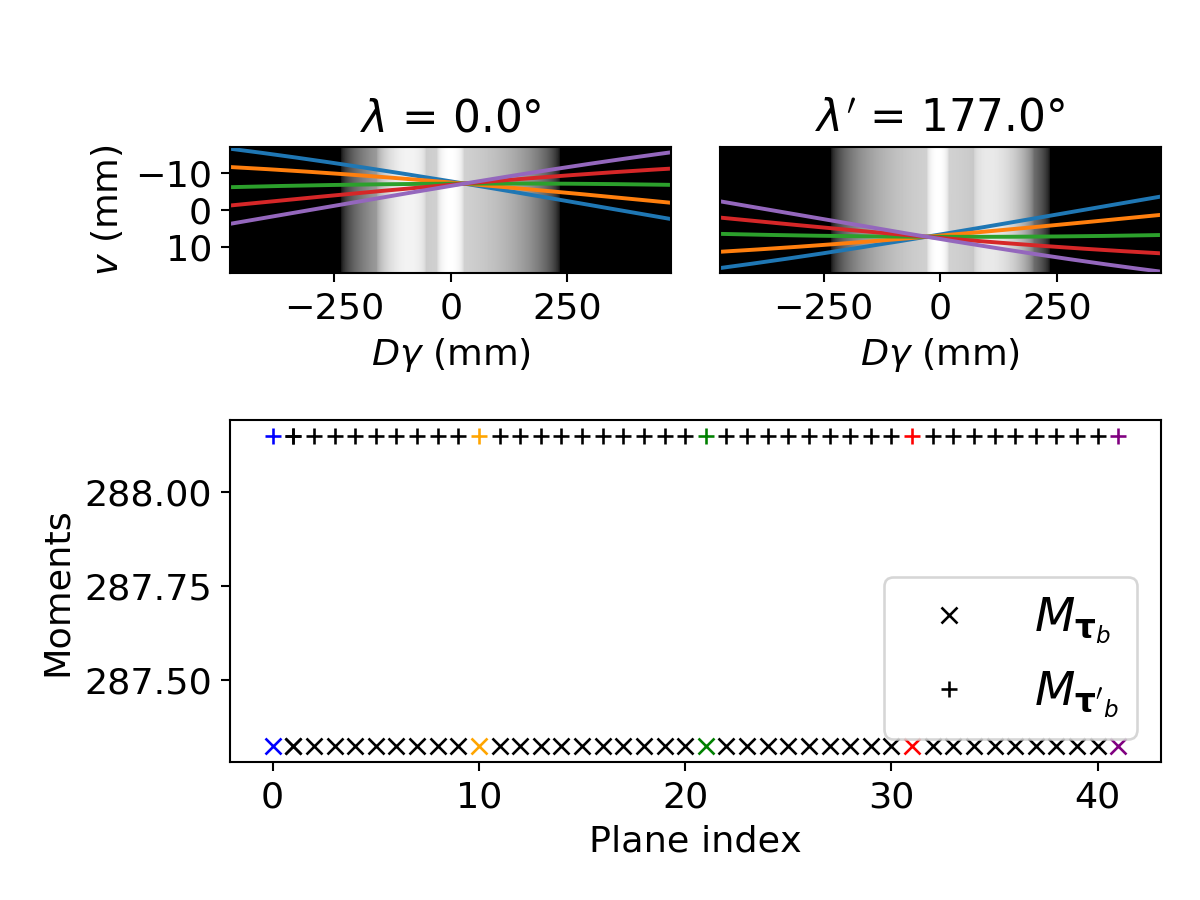

In [28]:
fig = plt.figure(dpi=150)
plt.rcParams['font.size'] = '14'
ax = fig.add_gridspec(4,2)
ax1=fig.add_subplot(ax[2:4,0:2])
colors = ["k"]*pair_e.v0.shape[1]
colors[0] = "b"
colors[-1] = "purple"
colors[pair_e.v0.shape[1]//4] = "orange"
colors[3*pair_e.v0.shape[1]//4] = "red"
colors[pair_e.v0.shape[1]//2] = "g"
for i in range(pair_e.v0.shape[1]):
    plt.plot(i, pair_e.m0[i], 'x', color=colors[i])
    plt.plot(i, pair_e.m1[i], '+', color=colors[i])
plt.plot(1, pair_e.m0[1], 'kx', label=r"$M_{\mathbf{\tau}_b}$")
plt.plot(1, pair_e.m1[1], 'k+', label=r"$M_{\mathbf{\tau'}_b}$")
plt.legend(loc = "lower right", fontsize = 18)
plt.xlabel("Plane index")
plt.ylabel("Moments")
ax1 = fig.add_subplot(ax[0:2, 0])
plt.title(r"$\lambda$ = %.1f°"%(pair_e.g0[2]*180/np.pi))
plt.imshow(pair_e.p0, cmap = "gray",extent=(1113.*pair_e.gamma0[0], 1113.*pair_e.gamma0[-1], pair_e.v_det0[-1], pair_e.v_det0[0]),aspect=8)
#planes
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,0])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,pair_e.v0.shape[1]//4])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,pair_e.v0.shape[1]//2])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,3*pair_e.v0.shape[1]//4])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,-1])
# plt.xticks([])
plt.xlabel(r"$D\gamma$ (mm)")
plt.ylabel(r"$v$ (mm)")
ax1 = fig.add_subplot(ax[0:2, 1])
plt.title(r"$\lambda'$ = %.1f°"%(pair_e.g1[2]*180/np.pi))
plt.imshow(pair_e.p1, cmap = "gray",extent=(1113.*pair_e.gamma1[0], 1113.*pair_e.gamma1[-1], pair_e.v_det1[-1], pair_e.v_det1[0]),aspect=8)
#planes
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,0])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,pair_e.v1.shape[1]//4])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,pair_e.v1.shape[1]//2])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,3*pair_e.v1.shape[1]//4])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,-1])
plt.xlabel(r"$D\gamma$ (mm)")
# plt.ylabel(r"$v$ (mm)")
plt.yticks([])
plt.tight_layout()
# plt.savefig('/home/mmouchet/Documents/Conf&Papers/paper_dcc_global/60e40ddbfc767fe1cb7f613f/images/pair_sing.pdf')  
plt.show()

In [18]:
# PlotPairGeometry2Bis(pair_e)

<IPython.core.display.Javascript object>


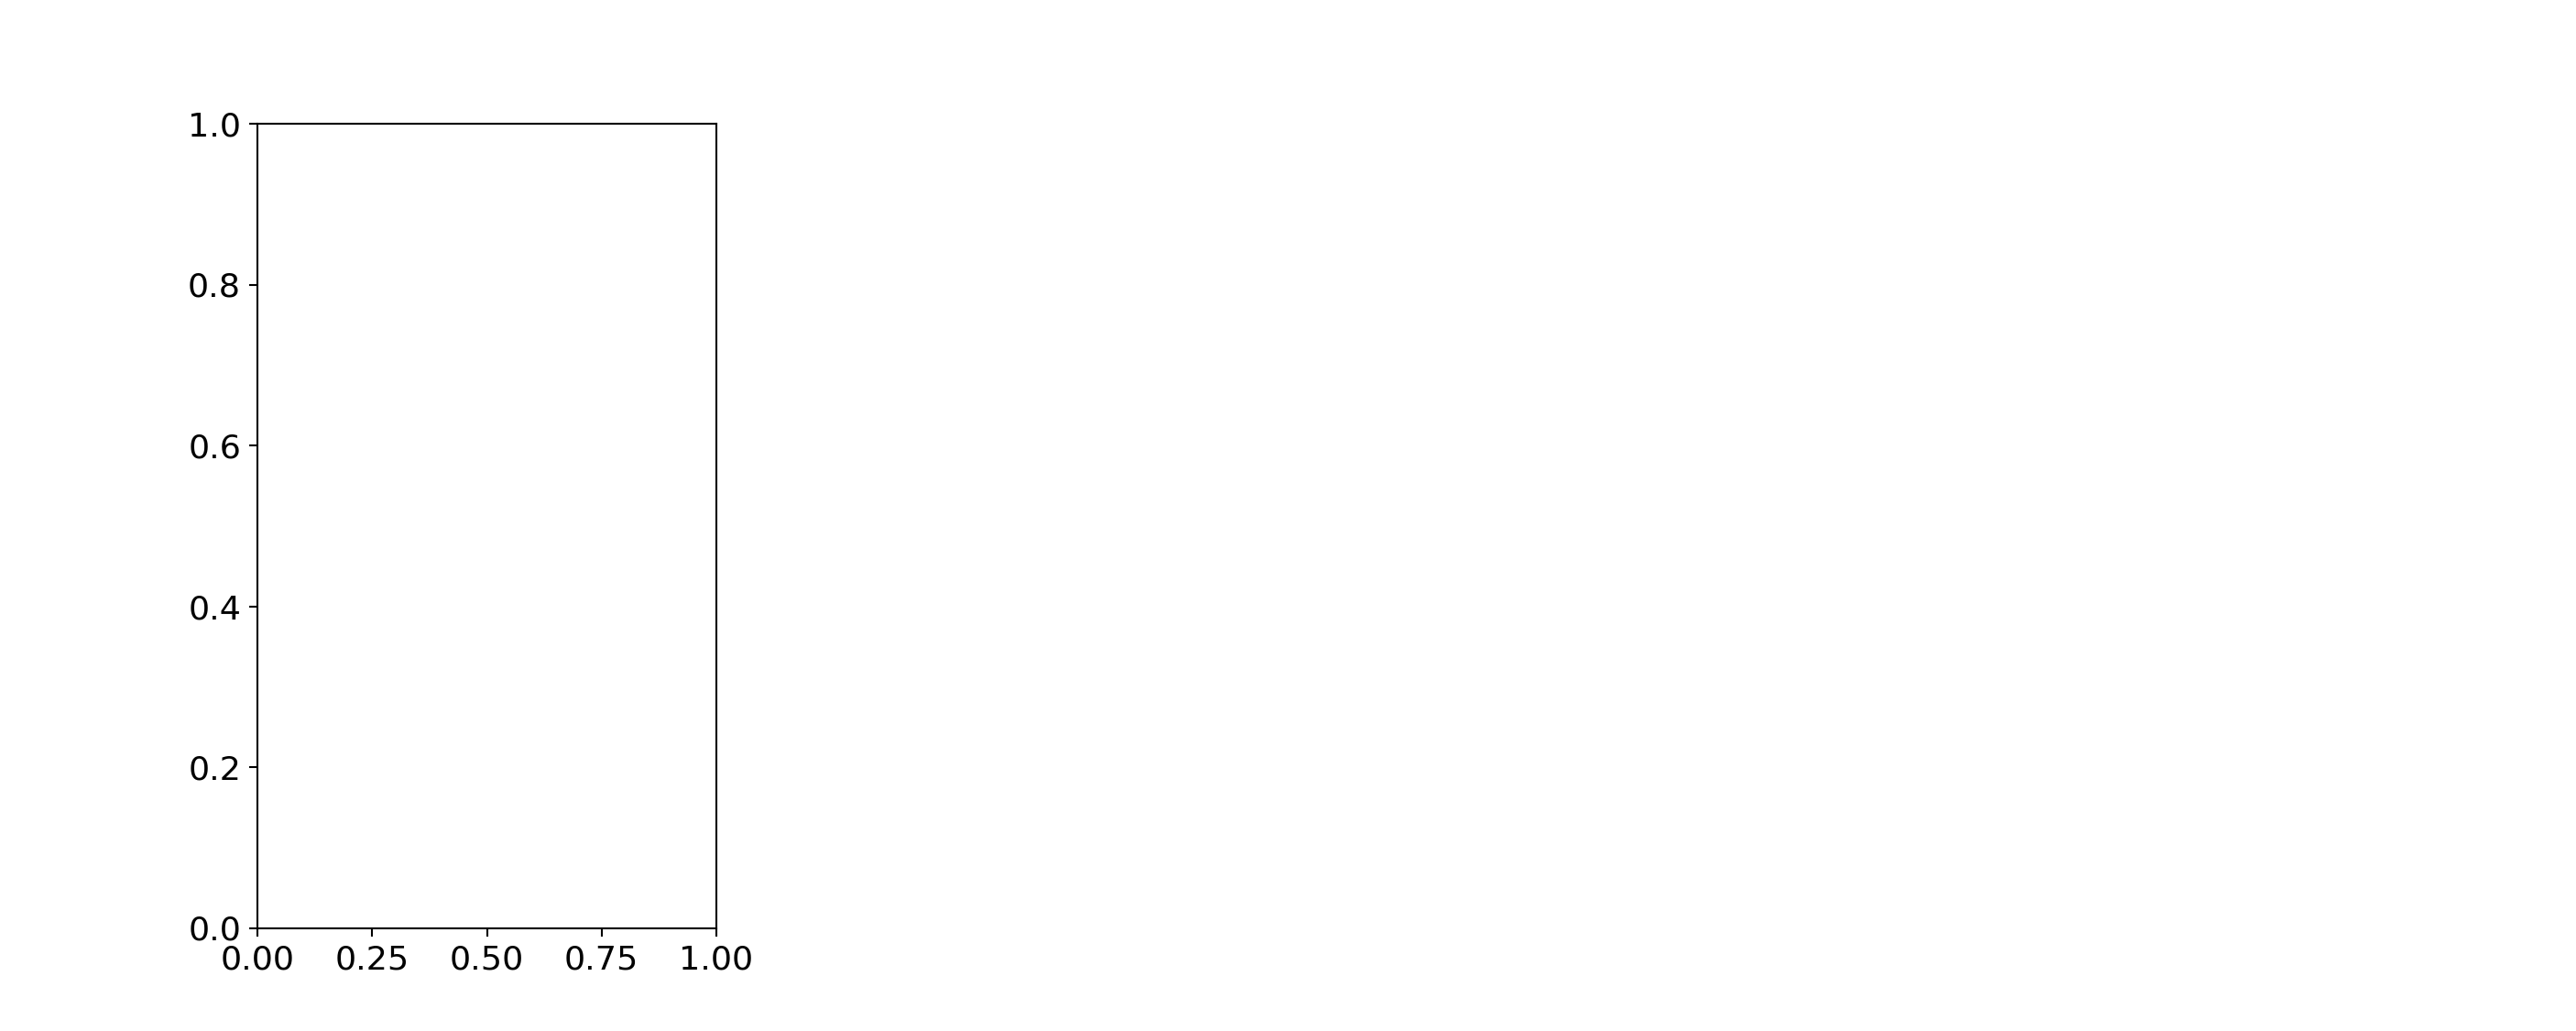

NameError: name 'pair_bp' is not defined

In [19]:
fig = plt.figure(dpi=150,figsize=(15,6))
plt.rcParams['font.size'] = '14'
ax = fig.add_gridspec(2, 8)
ax1 = fig.add_subplot(ax[0:2,0:2])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, wspace=1)
plt.plot(pair_bp.m0, 'x', color="#5e3c99", label=r"$M_{j'}$")
plt.plot(pair_bp.m1, '+', color = "#fdb863", label=r"$M_{j'}'$")
plt.xlabel("Virtual detector line $r_{j'}$")
plt.ylabel("Moments (rad)")
plt.legend()
ax1 = fig.add_subplot(ax[0, 2:5])
plt.title(r"$\lambda$ = %.1f°"%(pair_e.g0[2]*180/np.pi))
plt.imshow(pair_e.p0, cmap = "gray",extent=(1113.*pair_e.gamma0[0], 1113.*pair_e.gamma0[-1], pair_e.v_det0[-1], pair_e.v_det0[0]),aspect=4.5)
plt.xlabel(r"$D\gamma$ (mm)")
plt.ylabel(r"$v$ (mm)")
ax1 = fig.add_subplot(ax[1, 2:5])
plt.title(r"$\lambda'$ = %.1f°"%(pair_e.g1[2]*180/np.pi))
plt.imshow(pair_e.p1, cmap = "gray",extent=(1113.*pair_e.gamma0[0], 1113.*pair_e.gamma0[-1], pair_e.v_det0[-1], pair_e.v_det0[0]),aspect=4.5)
plt.xlabel(r"$D\gamma$ (mm)")
plt.ylabel(r"$v$ (mm)")
ax1 = fig.add_subplot(ax[0, 5:8])
plt.title(r"$\lambda$ = %.1f°"%(pair_e.g0[2]*180/np.pi))
plt.imshow(pair_bp.weight0, cmap = "gray",extent=(pair_bp.volOrigin0[0],pair_bp.volOtherCorner0[0], pair_bp.volOrigin0[1],pair_bp.volOtherCorner0[1]), aspect=22.75)
plt.xlabel(r"$b$ (mm)")
plt.ylabel(r"$r$ (mm)")
ax1 = fig.add_subplot(ax[1, 5:8])
plt.title(r"$\lambda'$ = %.1f°"%(pair_e.g1[2]*180/np.pi))
plt.imshow(pair_bp.weight1, cmap = "gray",extent=(pair_bp.volOrigin0[0],pair_bp.volOtherCorner0[0], pair_bp.volOrigin0[1],pair_bp.volOtherCorner0[1]),aspect=22.75)
plt.xlabel(r"$b$ (mm)")
plt.ylabel(r"$r$ (mm)")
plt.show()

<IPython.core.display.Javascript object>


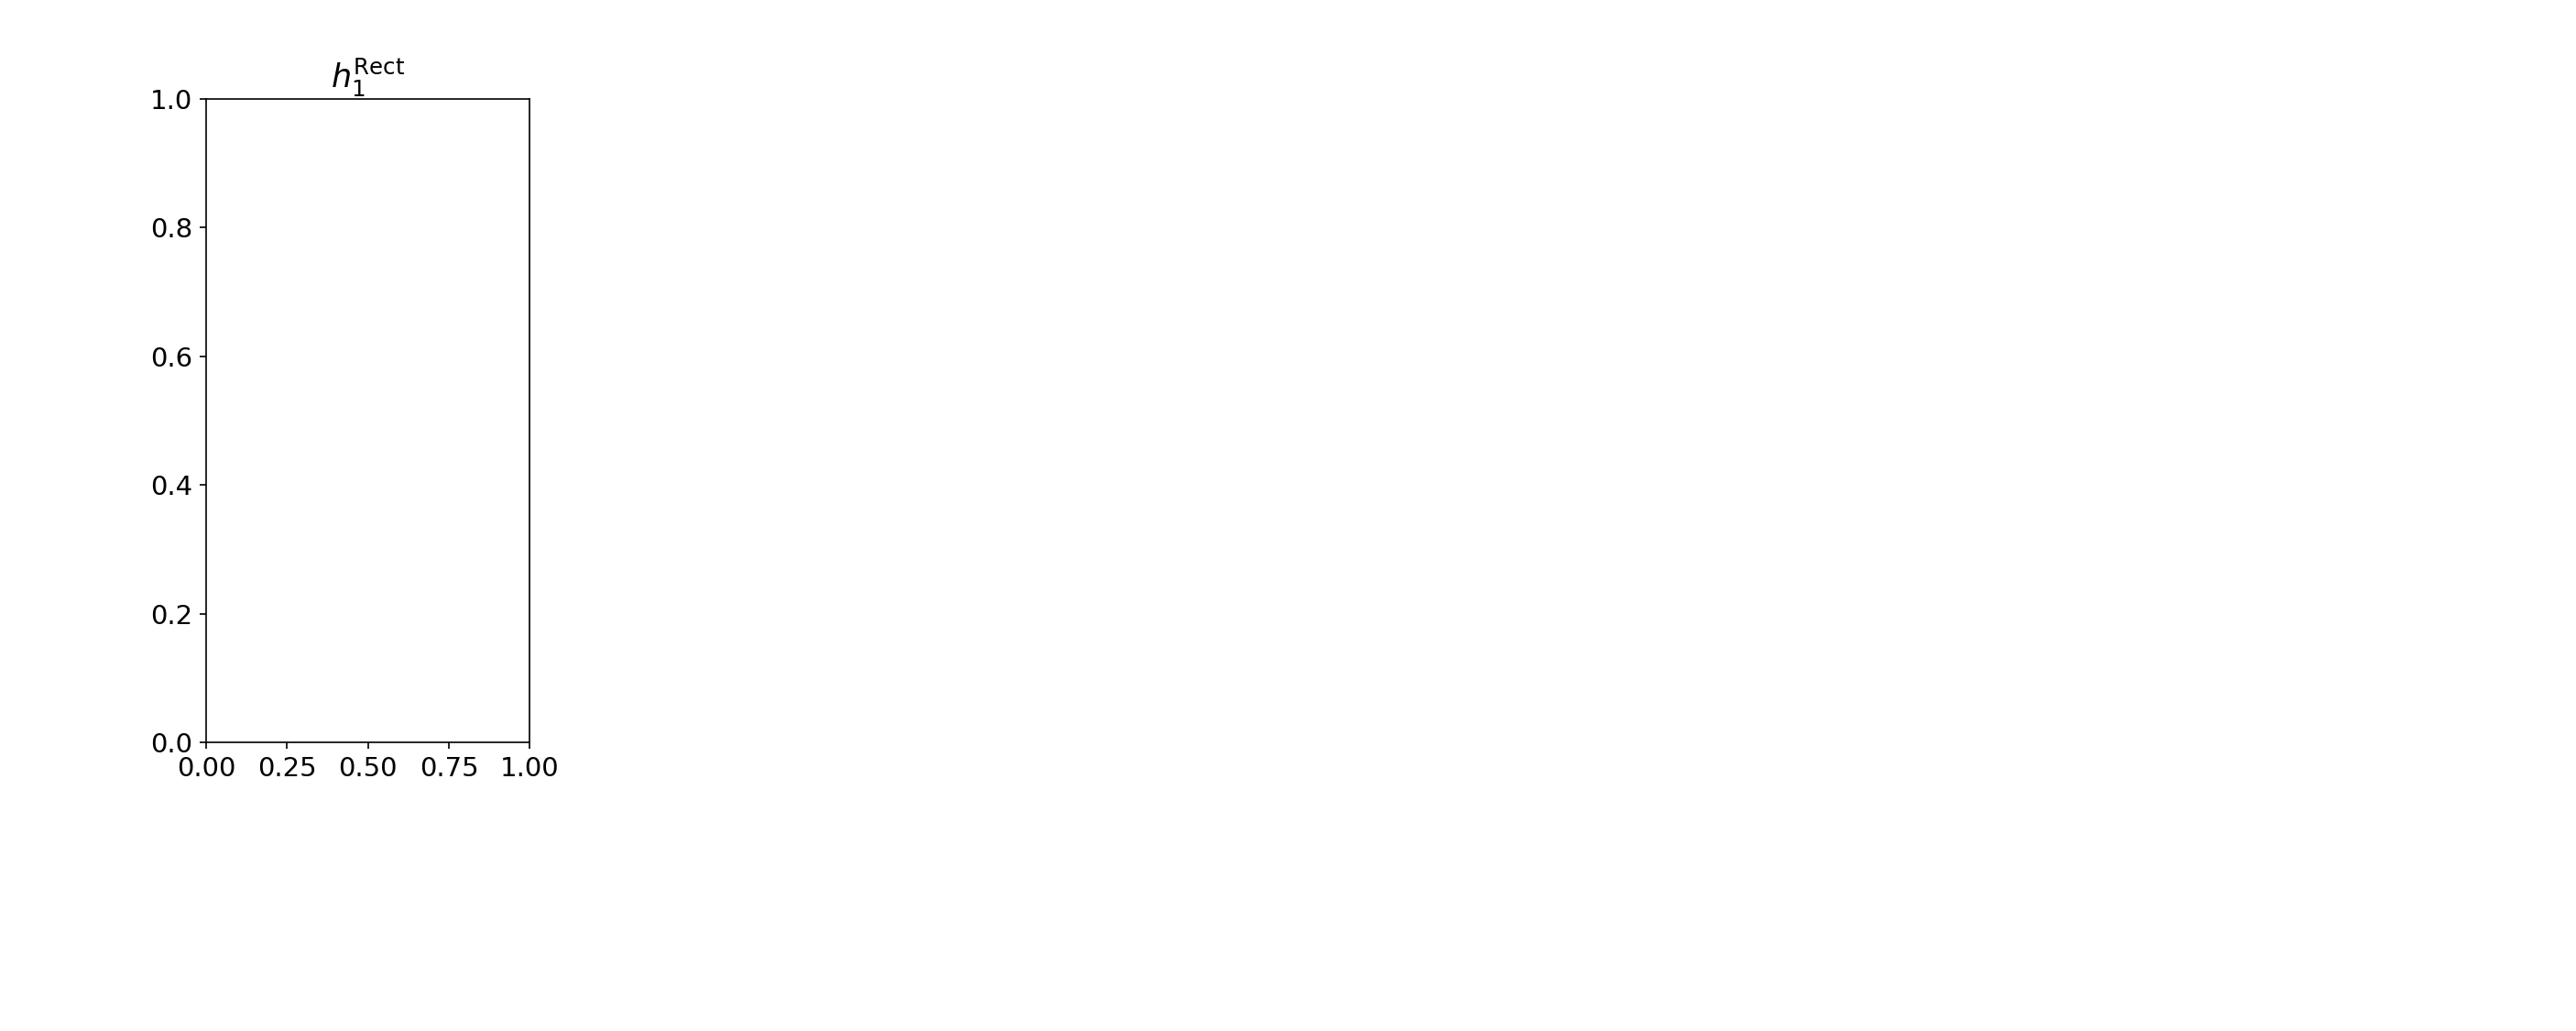

AttributeError: 'ProjectionsPairBeta' object has no attribute 'mhr0'

In [20]:
fig = plt.figure(figsize=(15,6), dpi=150)
plt.rcParams['font.size'] = '14'
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, wspace=1)
ax = fig.add_gridspec(2, 9)
ax1 = fig.add_subplot(ax[0:2,0:2])
plt.title(r"$h_1^\mathrm{Rect}$")
plt.plot(pair_e.mhr0, 'x', color="#5e3c99", label=r"$M_{\mathbf{\tau}_b}$")
plt.plot(pair_e.mhr1, '+', color = "#fdb863", label=r"$M_{\mathbf{\tau}'_b}$")
plt.legend()
plt.xlabel(r"Plane $b$")
plt.ylabel("Moments (rad)")
ax1 = fig.add_subplot(ax[0:2,2:4])
plt.title(r"$h_{0.2}^\mathrm{Hann}$")
plt.plot(pair_e.m0, 'x', color="#5e3c99", label=r"$M_{\mathbf{\tau}_b}$")
plt.plot(pair_e.m1, '+', color = "#fdb863", label=r"$M_{\mathbf{\tau}'_b}$")
plt.legend()
plt.xlabel(r"Plane $b$")
ax1 = fig.add_subplot(ax[0:2,4:6])
plt.title(r"$1^\mathrm{st}$ order")
plt.plot(pair_e.mk0, 'x', color="#5e3c99", label=r"$M_{\mathbf{\tau}_b}$")
plt.plot(pair_e.mk1, '+', color = "#fdb863", label=r"$M_{\mathbf{\tau}'_b}$")
plt.legend()
plt.xlabel(r"Plane $b$")
ax1 = fig.add_subplot(ax[0, 6:9])
plt.title(r"$\lambda$ = %.1f°"%(pair_e.g0[2]*180/np.pi))
plt.imshow(pair_e.p0, cmap = "gray",extent=(1113.*pair_e.gamma0[0], 1113.*pair_e.gamma0[-1], pair_e.v_det0[-1], pair_e.v_det0[0]),aspect=4.5)
#planes
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,0])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,pair_e.v0.shape[1]//4])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,pair_e.v0.shape[1]//2])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,3*pair_e.v0.shape[1]//4])
plt.plot(1113.*pair_e.gamma0, pair_e.v0[:,-1])
plt.xticks([])
plt.ylabel(r"$v$ (mm)")
ax1 = fig.add_subplot(ax[1, 6:9])
plt.title(r"$\lambda'$ = %.1f°"%(pair_e.g1[2]*180/np.pi))
plt.imshow(pair_e.p1, cmap = "gray",extent=(1113.*pair_e.gamma1[0], 1113.*pair_e.gamma1[-1], pair_e.v_det1[-1], pair_e.v_det1[0]),aspect=4.5)
#planes
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,0])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,pair_e.v1.shape[1]//4])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,pair_e.v1.shape[1]//2])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,3*pair_e.v1.shape[1]//4])
plt.plot(1113.*pair_e.gamma1, pair_e.v1[:,-1])
plt.xlabel(r"$D\gamma$ (mm)")
plt.ylabel(r"$v$ (mm)")
# plt.savefig('/home/mmouchet/Documents/Conf&Papers/paper_dcc_global/60e40ddbfc767fe1cb7f613f/images/pair_sing_good.pdf')  
plt.show()

In [ ]:
# from WeLovePlots import *
# PlotPairGeometry2(pair_bp)
# PlotPairGeometry2Bis(pair_e)

In [ ]:
# plt.figure()
# plt.subplot(121)
# plt.plot(pair.I20)
# plt.plot(pair.I21,'--')
# plt.subplot(122)
# plt.plot(pair.I10)
# plt.plot(pair.I11,'--')
# # plt.subplot(133)
# # plt.plot(pair.w0[:, 0])
# # plt.plot(pair.sdd/np.sqrt(pair.sdd**2+pair.v0[:,0]**2),'--')
# # # plt.plot(pair.w1[:, 0])
# # # plt.plot(np.sign(pair.B_gamma1[:,0])*pair.sdd/np.sqrt(pair.sdd**2+pair.v1[:,0]**2),'--')
# plt.show()


In [ ]:
# plt.figure()
# plt.subplot(121)
# plt.plot(pair.gamma0, pair.coeffs0)
# ax = plt.twinx()
# ax.plot(pair.gamma0, np.sum(pair.proj_interp0, axis=1),'r')
# plt.subplot(122)
# plt.plot(pair.gamma1, pair.coeffs1)
# ax = plt.twinx()
# ax.plot(pair.gamma1, np.sum(pair.proj_interp1, axis=1),'r')
# plt.show()